## multi-to-multi step forecast

In [3]:
import os
import math
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

filename = 'dataset/shampoo-three-year.csv'

#### preprocessing for time-step forecasting

In [293]:
dataset = pd.read_csv(filename)
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
origin_series = dataset.values

"""
시계열 예측시에는 t, t-1 의 차이값을 value로 활용

참고:

original data
diff data
-->

266 145 183 119 ... 224
       -120  37  -63 ...   -7
       
"""
def difference(series, interval=1):
    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_ordered(series, x_steps=1, y_steps=1, split_index=12):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        train_len = split_index
        x_train = x_data[:train_len, :]
        x_test = x_data[train_len:, :]
        y_train =  y_data[:train_len, :]
        y_test = y_data[train_len:, :]
        return (x_train, x_test, y_train, y_test)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

"""
split origin dataset
"""

# split origin dataset
origin_x_train, origin_x_test, origin_y_train, origin_y_test = make_timeseries_dataset_ordered(series=origin_series,
                                                                                               x_steps=4, y_steps=3, split_index=17)
# transform original value to diff value
diff_interval = 1
diff_series = difference(origin_series, diff_interval)
# min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(diff_series)
# split and make timeseries
x_train, x_test, y_train, y_test = make_timeseries_dataset_ordered(series=scaled_series, 
                                                                   x_steps=4, y_steps=3, split_index=17)

In [294]:
print('training X data shape:', origin_x_train.shape)
print('training Y data shape:', origin_y_train.shape)
print('test X data shape:', origin_x_test.shape)
print('test Y data shape:', origin_y_test.shape)

training X data shape: (17, 4)
training Y data shape: (17, 3)
test X data shape: (13, 4)
test Y data shape: (13, 3)


In [295]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (17, 4)
training Y data shape: (17, 3)
test X data shape: (12, 4)
test Y data shape: (12, 3)


In [296]:
# data reshape : for trim batch size (train, predict in Neural Networks)
x_train = x_train[:16, :]
y_train = y_train[:16, :]
x_test = x_test[:12, :]
y_test = y_test[:12, :]

In [297]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (16, 4)
training Y data shape: (16, 3)
test X data shape: (12, 4)
test Y data shape: (12, 3)


#### change shape for (LSTM or RNN)

In [274]:
"""
(size, timestep, feature) 의 형식으로 맞춰줘야 함
size : batch를 돌 데이터 사이즈
timestep : input의 time 개수 (X_t1, X_t2...)
feature : feature의 개수 (X = x1, x2 ...) [ex: x1 - 키, x2 - 몸무게 ...]
"""

time_step = 4
feature_num = 1

x_train_series = x_train.reshape(x_train.shape[0], time_step, feature_num)
x_test_series = x_test.reshape(x_test.shape[0], time_step, feature_num)

#### LSTM modeling code

In [275]:
num_epochs = 1000
batch_size=4
forecast_step = 3

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(forecast_step)) # output = forecast_step
model.compile(loss='mean_squared_error', optimizer='adam')

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train_series, y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
16/16 [==============================] - 1s 91ms/step - loss: 0.3049
epochs : 1
Epoch 1/1
16/16 [==============================] - 0s 594us/step - loss: 0.2947
epochs : 2
Epoch 1/1
16/16 [==============================] - 0s 944us/step - loss: 0.2848
epochs : 3
Epoch 1/1
16/16 [==============================] - 0s 645us/step - loss: 0.2751
epochs : 4
Epoch 1/1
16/16 [==============================] - 0s 707us/step - loss: 0.2658
epochs : 5
Epoch 1/1
16/16 [==============================] - 0s 875us/step - loss: 0.2568
epochs : 6
Epoch 1/1
16/16 [==============================] - 0s 731us/step - loss: 0.2481
epochs : 7
Epoch 1/1
16/16 [==============================] - 0s 949us/step - loss: 0.2397
epochs : 8
Epoch 1/1
16/16 [==============================] - 0s 832us/step - loss: 0.2316
epochs : 9
Epoch 1/1
16/16 [==============================] - 0s 838us/step - loss: 0.2239
epochs : 10
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.2163
e

16/16 [==============================] - 0s 824us/step - loss: 0.0390
epochs : 90
Epoch 1/1
16/16 [==============================] - 0s 648us/step - loss: 0.0389
epochs : 91
Epoch 1/1
16/16 [==============================] - 0s 546us/step - loss: 0.0389
epochs : 92
Epoch 1/1
16/16 [==============================] - 0s 541us/step - loss: 0.0388
epochs : 93
Epoch 1/1
16/16 [==============================] - 0s 730us/step - loss: 0.0388
epochs : 94
Epoch 1/1
16/16 [==============================] - 0s 751us/step - loss: 0.0387
epochs : 95
Epoch 1/1
16/16 [==============================] - 0s 647us/step - loss: 0.0387
epochs : 96
Epoch 1/1
16/16 [==============================] - 0s 817us/step - loss: 0.0386
epochs : 97
Epoch 1/1
16/16 [==============================] - 0s 995us/step - loss: 0.0386
epochs : 98
Epoch 1/1
16/16 [==============================] - 0s 661us/step - loss: 0.0385
epochs : 99
Epoch 1/1
16/16 [==============================] - 0s 537us/step - loss: 0.0385
epochs : 1

16/16 [==============================] - 0s 1ms/step - loss: 0.0361
epochs : 178
Epoch 1/1
16/16 [==============================] - 0s 788us/step - loss: 0.0360
epochs : 179
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0360
epochs : 180
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0360
epochs : 181
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0360
epochs : 182
Epoch 1/1
16/16 [==============================] - 0s 817us/step - loss: 0.0360
epochs : 183
Epoch 1/1
16/16 [==============================] - 0s 760us/step - loss: 0.0359
epochs : 184
Epoch 1/1
16/16 [==============================] - 0s 643us/step - loss: 0.0359
epochs : 185
Epoch 1/1
16/16 [==============================] - 0s 676us/step - loss: 0.0359
epochs : 186
Epoch 1/1
16/16 [==============================] - 0s 578us/step - loss: 0.0359
epochs : 187
Epoch 1/1
16/16 [==============================] - 0s 603us/step - loss: 0.0359
epochs :

16/16 [==============================] - 0s 791us/step - loss: 0.0346
epochs : 266
Epoch 1/1
16/16 [==============================] - 0s 717us/step - loss: 0.0346
epochs : 267
Epoch 1/1
16/16 [==============================] - 0s 617us/step - loss: 0.0346
epochs : 268
Epoch 1/1
16/16 [==============================] - 0s 757us/step - loss: 0.0346
epochs : 269
Epoch 1/1
16/16 [==============================] - 0s 766us/step - loss: 0.0345
epochs : 270
Epoch 1/1
16/16 [==============================] - 0s 685us/step - loss: 0.0345
epochs : 271
Epoch 1/1
16/16 [==============================] - 0s 795us/step - loss: 0.0345
epochs : 272
Epoch 1/1
16/16 [==============================] - 0s 798us/step - loss: 0.0345
epochs : 273
Epoch 1/1
16/16 [==============================] - 0s 951us/step - loss: 0.0345
epochs : 274
Epoch 1/1
16/16 [==============================] - 0s 731us/step - loss: 0.0345
epochs : 275
Epoch 1/1
16/16 [==============================] - 0s 663us/step - loss: 0.0345


16/16 [==============================] - 0s 850us/step - loss: 0.0335
epochs : 354
Epoch 1/1
16/16 [==============================] - 0s 640us/step - loss: 0.0335
epochs : 355
Epoch 1/1
16/16 [==============================] - 0s 511us/step - loss: 0.0335
epochs : 356
Epoch 1/1
16/16 [==============================] - 0s 646us/step - loss: 0.0335
epochs : 357
Epoch 1/1
16/16 [==============================] - 0s 734us/step - loss: 0.0335
epochs : 358
Epoch 1/1
16/16 [==============================] - 0s 715us/step - loss: 0.0335
epochs : 359
Epoch 1/1
16/16 [==============================] - 0s 603us/step - loss: 0.0335
epochs : 360
Epoch 1/1
16/16 [==============================] - 0s 592us/step - loss: 0.0335
epochs : 361
Epoch 1/1
16/16 [==============================] - 0s 633us/step - loss: 0.0334
epochs : 362
Epoch 1/1
16/16 [==============================] - 0s 678us/step - loss: 0.0334
epochs : 363
Epoch 1/1
16/16 [==============================] - 0s 575us/step - loss: 0.0334


16/16 [==============================] - 0s 723us/step - loss: 0.0326
epochs : 442
Epoch 1/1
16/16 [==============================] - 0s 635us/step - loss: 0.0326
epochs : 443
Epoch 1/1
16/16 [==============================] - 0s 622us/step - loss: 0.0326
epochs : 444
Epoch 1/1
16/16 [==============================] - 0s 758us/step - loss: 0.0326
epochs : 445
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0326
epochs : 446
Epoch 1/1
16/16 [==============================] - 0s 756us/step - loss: 0.0326
epochs : 447
Epoch 1/1
16/16 [==============================] - 0s 716us/step - loss: 0.0325
epochs : 448
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0325
epochs : 449
Epoch 1/1
16/16 [==============================] - 0s 590us/step - loss: 0.0325
epochs : 450
Epoch 1/1
16/16 [==============================] - 0s 670us/step - loss: 0.0325
epochs : 451
Epoch 1/1
16/16 [==============================] - 0s 648us/step - loss: 0.0325
epoc

16/16 [==============================] - 0s 632us/step - loss: 0.0317
epochs : 530
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0317
epochs : 531
Epoch 1/1
16/16 [==============================] - 0s 930us/step - loss: 0.0317
epochs : 532
Epoch 1/1
16/16 [==============================] - 0s 583us/step - loss: 0.0317
epochs : 533
Epoch 1/1
16/16 [==============================] - 0s 670us/step - loss: 0.0317
epochs : 534
Epoch 1/1
16/16 [==============================] - 0s 711us/step - loss: 0.0317
epochs : 535
Epoch 1/1
16/16 [==============================] - 0s 980us/step - loss: 0.0317
epochs : 536
Epoch 1/1
16/16 [==============================] - 0s 608us/step - loss: 0.0317
epochs : 537
Epoch 1/1
16/16 [==============================] - 0s 768us/step - loss: 0.0317
epochs : 538
Epoch 1/1
16/16 [==============================] - 0s 635us/step - loss: 0.0317
epochs : 539
Epoch 1/1
16/16 [==============================] - 0s 575us/step - loss: 0.0317
ep

16/16 [==============================] - 0s 854us/step - loss: 0.0309
epochs : 618
Epoch 1/1
16/16 [==============================] - 0s 640us/step - loss: 0.0309
epochs : 619
Epoch 1/1
16/16 [==============================] - 0s 545us/step - loss: 0.0309
epochs : 620
Epoch 1/1
16/16 [==============================] - 0s 573us/step - loss: 0.0309
epochs : 621
Epoch 1/1
16/16 [==============================] - 0s 683us/step - loss: 0.0309
epochs : 622
Epoch 1/1
16/16 [==============================] - 0s 526us/step - loss: 0.0309
epochs : 623
Epoch 1/1
16/16 [==============================] - 0s 737us/step - loss: 0.0309
epochs : 624
Epoch 1/1
16/16 [==============================] - 0s 607us/step - loss: 0.0309
epochs : 625
Epoch 1/1
16/16 [==============================] - 0s 665us/step - loss: 0.0309
epochs : 626
Epoch 1/1
16/16 [==============================] - 0s 636us/step - loss: 0.0309
epochs : 627
Epoch 1/1
16/16 [==============================] - 0s 633us/step - loss: 0.0309


16/16 [==============================] - 0s 741us/step - loss: 0.0302
epochs : 706
Epoch 1/1
16/16 [==============================] - 0s 777us/step - loss: 0.0302
epochs : 707
Epoch 1/1
16/16 [==============================] - 0s 656us/step - loss: 0.0302
epochs : 708
Epoch 1/1
16/16 [==============================] - 0s 836us/step - loss: 0.0302
epochs : 709
Epoch 1/1
16/16 [==============================] - 0s 708us/step - loss: 0.0302
epochs : 710
Epoch 1/1
16/16 [==============================] - 0s 742us/step - loss: 0.0302
epochs : 711
Epoch 1/1
16/16 [==============================] - 0s 826us/step - loss: 0.0302
epochs : 712
Epoch 1/1
16/16 [==============================] - 0s 828us/step - loss: 0.0302
epochs : 713
Epoch 1/1
16/16 [==============================] - 0s 832us/step - loss: 0.0302
epochs : 714
Epoch 1/1
16/16 [==============================] - 0s 717us/step - loss: 0.0302
epochs : 715
Epoch 1/1
16/16 [==============================] - 0s 921us/step - loss: 0.0302


16/16 [==============================] - 0s 765us/step - loss: 0.0296
epochs : 794
Epoch 1/1
16/16 [==============================] - 0s 654us/step - loss: 0.0296
epochs : 795
Epoch 1/1
16/16 [==============================] - 0s 810us/step - loss: 0.0296
epochs : 796
Epoch 1/1
16/16 [==============================] - 0s 734us/step - loss: 0.0296
epochs : 797
Epoch 1/1
16/16 [==============================] - 0s 580us/step - loss: 0.0296
epochs : 798
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0296
epochs : 799
Epoch 1/1
16/16 [==============================] - 0s 759us/step - loss: 0.0296
epochs : 800
Epoch 1/1
16/16 [==============================] - 0s 707us/step - loss: 0.0296
epochs : 801
Epoch 1/1
16/16 [==============================] - 0s 822us/step - loss: 0.0296
epochs : 802
Epoch 1/1
16/16 [==============================] - 0s 671us/step - loss: 0.0296
epochs : 803
Epoch 1/1
16/16 [==============================] - 0s 635us/step - loss: 0.0296
ep

16/16 [==============================] - 0s 733us/step - loss: 0.0292
epochs : 882
Epoch 1/1
16/16 [==============================] - 0s 642us/step - loss: 0.0292
epochs : 883
Epoch 1/1
16/16 [==============================] - 0s 501us/step - loss: 0.0292
epochs : 884
Epoch 1/1
16/16 [==============================] - 0s 650us/step - loss: 0.0291
epochs : 885
Epoch 1/1
16/16 [==============================] - 0s 668us/step - loss: 0.0291
epochs : 886
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0291
epochs : 887
Epoch 1/1
16/16 [==============================] - 0s 569us/step - loss: 0.0291
epochs : 888
Epoch 1/1
16/16 [==============================] - 0s 594us/step - loss: 0.0291
epochs : 889
Epoch 1/1
16/16 [==============================] - 0s 618us/step - loss: 0.0291
epochs : 890
Epoch 1/1
16/16 [==============================] - 0s 624us/step - loss: 0.0291
epochs : 891
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0291
epoc

16/16 [==============================] - 0s 605us/step - loss: 0.0288
epochs : 970
Epoch 1/1
16/16 [==============================] - 0s 499us/step - loss: 0.0288
epochs : 971
Epoch 1/1
16/16 [==============================] - 0s 575us/step - loss: 0.0288
epochs : 972
Epoch 1/1
16/16 [==============================] - 0s 740us/step - loss: 0.0288
epochs : 973
Epoch 1/1
16/16 [==============================] - 0s 640us/step - loss: 0.0288
epochs : 974
Epoch 1/1
16/16 [==============================] - 0s 628us/step - loss: 0.0288
epochs : 975
Epoch 1/1
16/16 [==============================] - 0s 727us/step - loss: 0.0288
epochs : 976
Epoch 1/1
16/16 [==============================] - 0s 599us/step - loss: 0.0288
epochs : 977
Epoch 1/1
16/16 [==============================] - 0s 602us/step - loss: 0.0288
epochs : 978
Epoch 1/1
16/16 [==============================] - 0s 728us/step - loss: 0.0288
epochs : 979
Epoch 1/1
16/16 [==============================] - 0s 638us/step - loss: 0.0288


# test

In [276]:
# get RMSE
train_predict = model.predict(x_train_series, batch_size=batch_size)
print(x_train_series[:3])
print("-------------------")
print(y_train[:3])
print("-------------------")
print(train_predict[:3])

[[[0.18000416]
  [0.50696321]
  [0.29702764]
  [0.55643317]]

 [[0.50696321]
  [0.29702764]
  [0.55643317]
  [0.40511328]]

 [[0.29702764]
  [0.55643317]
  [0.40511328]
  [0.56121388]]]
-------------------
[[0.40511328 0.56121388 0.41446685]
 [0.56121388 0.41446685 0.36374974]
 [0.41446685 0.36374974 0.28434837]]
-------------------
[[0.4211216  0.4156653  0.43038034]
 [0.4677091  0.3746751  0.4784752 ]
 [0.4096086  0.42050594 0.41606137]]


In [277]:
# m_x_train1 = np.apply_along_axis(lambda x: scaler.inverse_transform(x), 1, x_train_series[0])
m_y_train1 = scaler.inverse_transform(y_train[:1])
m_y_pred1 = scaler.inverse_transform(train_predict[:1])

In [278]:
m_y_train1

array([[-11.8,  63.3,  -7.3]])

In [279]:
# m_x_train2 = scaler.inverse_transform(x_train_series[1:2])
m_y_train2 = scaler.inverse_transform(y_train[1:2])
m_y_pred2 = scaler.inverse_transform(train_predict[1:2])

In [287]:
# r_x_train1 = m_x_train1 + origin_x_train[0]
r_y_train1 = m_y_train1 + origin_y_train[0]
r_y_pred1 = m_y_pred1 + origin_y_train[0]

# print(r_x_train1)
print(origin_y_train[1])
print(r_y_train1)
print(r_y_pred1)

[168.5 231.8 224.5]
[[168.5 231.8 224.5]]
[[176.20160036 161.77657509 232.1559837 ]]


In [298]:
# get RMSE
train_predict = model.predict(x_train_series, batch_size=batch_size)
diff_predict = scaler.inverse_transform(train_predict)
restored_prediction = diff_predict + origin_y_train[0:diff_predict.shape[0]]

# diff value와는 diff_interval만큼 데이터 개수의 차이가 있음. 
# original data에서 앞의 diff_interval만큼을 빼면 같은 크기, 같은 위치의 데이터가 됨.
origin_y_train_series = origin_y_train[diff_interval:]

train_score = math.sqrt(mean_squared_error(restored_prediction, origin_y_train_series))
print('Train score : RMSE: %f' % train_score)
for i in range(forecast_step):
    actual = [row[i] for row in origin_y_train_series]
    predicted = [forecast[i] for forecast in restored_prediction]
    rmse = math.sqrt(mean_squared_error(actual, predicted))
    print('Train score : t+%d RMSE: %f' % ((i+1), rmse))

Train score : RMSE: 83.256320
Train score : t+1 RMSE: 66.567795
Train score : t+2 RMSE: 87.298353
Train score : t+3 RMSE: 93.501716


# test end

In [300]:
# get RMSE
train_predict = model.predict(x_train_series, batch_size=batch_size)
diff_predict = scaler.inverse_transform(train_predict)
restored_predict = diff_predict + origin_y_train[0:diff_predict.shape[0]]

# diff value와는 diff_interval만큼 데이터 개수의 차이가 있음. 
# original data에서 앞의 diff_interval만큼을 빼면 같은 크기, 같은 위치의 데이터가 됨.
origin_y_train_series = origin_y_train[diff_interval:]

train_score = math.sqrt(mean_squared_error(restored_predict, origin_y_train_series))
print('Train score : RMSE: %f' % train_score)
for i in range(forecast_step):
    actual = [row[i] for row in origin_y_train_series]
    predict = [forecast[i] for forecast in restored_predict]
    rmse = math.sqrt(mean_squared_error(actual, predict))
    print('Train score : t+%d RMSE: %f' % ((i+1), rmse))

Train score : RMSE: 83.256320
Train score : t+1 RMSE: 66.567795
Train score : t+2 RMSE: 87.298353
Train score : t+3 RMSE: 93.501716


In [341]:
def show_train_fit(origin_y_train):
    train_predict = model.predict(x_train_series, batch_size=batch_size)
    yhat = scaler.inverse_transform(train_predict) 
#     yhat = scaler.inverse_transform(y_train) # 예측 말고 train 값 볼때
    yhat = yhat + origin_y_train[0:yhat.shape[0]]
    model.reset_states()
    return yhat

# def get_recent_prediction():
#     output = model.predict(x_train_series, batch_size=batch_size)
#     prediction = output[output.shape[0]-1]
#     yhat = [scaler.inverse_transform(x) for x in prediction]
#     model.reset_states()
#     return yhat

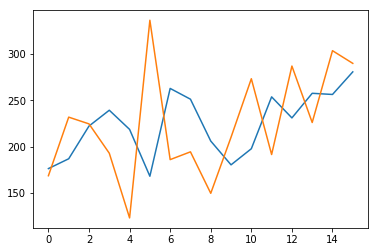

[[176.20160036 161.77657509 232.1559837 ]
 [186.81484413 205.35618858 247.99442482]
 [222.16269855 220.10540819 186.26712589]
 [239.26025105 168.58201675 142.09721413]
 [218.55754738 129.93069067 356.88926506]
 [167.94376984 332.04748297 227.11950912]
 [262.82355499 275.02181854 106.8330658 ]
 [251.17987671 159.15895157 212.76390839]
 [205.96547394 180.95092773 212.738448  ]
 [180.257761   221.39135513 297.02079086]
 [197.65366135 320.33071594 168.17387047]
 [253.70951538 237.15894547 256.07304382]
 [230.97013321 286.36282617 258.55775452]
 [257.55579567 287.80984497 261.15281448]
 [256.29605293 309.63207016 312.56325569]
 [280.70544777 345.31755295 386.28110275]]
[[168.5]
 [231.8]
 [224.5]
 [192.8]
 [122.9]
 [336.5]
 [185.9]
 [194.3]
 [149.5]
 [210.1]
 [273.3]
 [191.4]
 [287. ]
 [226. ]
 [303.6]
 [289.9]]


In [342]:
predictions = show_train_fit(origin_y_train)

plt.plot(predictions[:, :1]) # y_hat : blue line. t+1만 관찰.
plt.plot(origin_y_train[diff_interval:, :1]) # y_train_origin : yellow line. t+1만 관찰.
plt.show()

print(predictions)
print(origin_y_train[diff_interval:, :1])
# print(get_recent_prediction())

In [340]:
-- todo
x_train_series 때문에 한칸 밀린듯

SyntaxError: invalid syntax (<ipython-input-340-5edd6ecb85f5>, line 2)

## bitcoin data with LSTM

https://www.blockchain.com/ko/charts/market-price?timespan=60days